# AutoML: Data Science Made Really Easy

In [1]:
import pandas as pd
import featuretools as ft

In [2]:
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from hpsklearn import HyperoptEstimator, any_classifier
import numpy as np

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [3]:
train_df = pd.read_csv("data/train.csv")
train_df["Pclass"] = train_df["Pclass"].astype("category")
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
626,627,0,2,"Kirkland, Rev. Charles Leonard",male,57.00,0,0,219533,12.3500,NaN,Q
244,245,0,3,"Attalah, Mr. Sleiman",male,30.00,0,0,2694,7.2250,NaN,C
226,227,1,2,"Mellors, Mr. William John",male,19.00,0,0,SW/PP 751,10.5000,NaN,S
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
756,757,0,3,"Carlsson, Mr. August Sigfrid",male,28.00,0,0,350042,7.7958,NaN,S


In [4]:
train_df = train_df.drop(columns=["Name", "Cabin", "Ticket"])
train_features = train_df.drop(columns=["Survived"])
train_target = train_df["Survived"]

In [5]:
train_features.sample(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
301,302,3,male,NaN,2,0,23.2500,Q
53,54,2,female,29.0,1,0,26.0000,S
690,691,1,male,31.0,1,0,57.0000,S
871,872,1,female,47.0,1,1,52.5542,S
129,130,3,male,45.0,0,0,6.9750,S


In [6]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=train_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical})
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")

Entityset: titanic
  Entities:
    titanic (shape = [891, 8])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked

In [7]:
feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

Built 94 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


In [8]:
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [9]:
encoder = MultiColumnLabelEncoder()
label_matrix = feature_matrix[["Sex", "Embarked"]].astype(str)
label_matrix = encoder.fit_transform(label_matrix)

In [10]:
encoder = OneHotEncoder()
category_matrix = encoder.fit_transform(pd.concat([label_matrix, feature_matrix['Pclass']], axis=1))

In [11]:
numerical_matrix = feature_matrix.select_dtypes("number")
imputer = Imputer(strategy='median')
numerical_matrix = imputer.fit_transform(numerical_matrix)

In [12]:
imputed_matrix = np.concatenate([category_matrix.todense(), numerical_matrix], axis=1)

In [15]:
model = "kitchen-sink"
name = f"100_{model}_titanic"

estim = HyperoptEstimator(classifier=any_classifier(model),
                          max_evals=100,
                          trial_timeout=60,
                          fit_increment_dump_filename=f"results/models/{name}.pickle",
                          verbose=0,
                          seed=42
                          )

estim.fit(imputed_matrix,
          train_target,
          n_folds=5,    
          random_state=41,
          )

train_loss = estim.trials.best_trial["result"]["loss"]

print(train_loss)
print(estim.best_model())

with open(f"results/models/{train_loss:.3}_{name}_estimator.pickle", "wb+") as estimator:
    pickle.dump(estim, estimator)

/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/deadhead/miniconda3/envs/automl-talk/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter

0.16386083052749723
{'learner': XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9650688736808748,
       colsample_bytree=0.7263151008928389, gamma=1.6691357743417827,
       learning_rate=0.2168510528743872, max_delta_step=0, max_depth=10,
       min_child_weight=10, missing=nan, n_estimators=3600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01712777137082772, reg_lambda=2.8896229565510203,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.788870981192162), 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=False),), 'ex_preprocs': ()}


NameError: name 'pickle' is not defined

In [24]:
estim.trials.trials[0]

dict_keys(['state', 'tid', 'spec', 'result', 'misc', 'exp_key', 'owner', 'version', 'book_time', 'refresh_time'])

In [26]:
estim.trials.trials[0]['result']['loss']

{'duration': 0.38425183296203613,
 'loss': 0.18406285072951745,
 'loss_variance': 0.0001687457502368998,
 'status': 'ok'}

In [52]:
from collections import defaultdict
import seaborn as sns

%matplotlib inline

In [49]:
trial_results = defaultdict(list)
for trial in range(0,100):
    if 'loss' in estim.trials.trials[trial]['result']:
        trial_results['loss'].append(estim.trials.trials[trial]['result']['loss'])
        trial_results['loss_variance'].append(estim.trials.trials[0]['result']['loss_variance'])
    else:
        print(estim.trials.trials[trial]['result'])
        trial_results['loss'].append(None)
        trial_results['loss_variance'].append(None)
    for key, value in estim.trials.trials[trial]['misc']['idxs'].items():
        if value and "kitchen-sink." in key:
            trial_results['algorithm_type'].append(key.split(".")[1])
            break

{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}
{'status': 'fail', 'failure': 'TimeOut'}


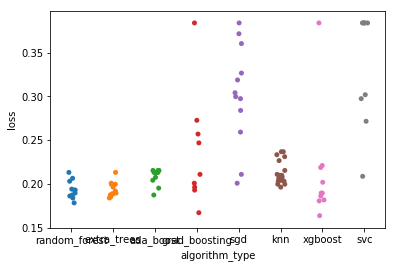

In [54]:
trial_df = pd.DataFrame(trial_results)
sns.stripplot(data = trial_df, x='algorithm_type', y='loss', jitter=True)